# TQuant Lab 交易策略開發實作-以月營收成長率為選股指標

本範例運用TQuant Lab為研究工具，以月營收成長率作為選股指標建立交易策略，並回測分析其績效表現。交易策略建立流程涵蓋以下 7 個步驟，以下依此分為 7 個章節說明。

1. 匯入套件 (Import Packages)

2. 獲取歷史資料 (Get History Data) 
3. 將交易資料綁入zipline回測架構中 (Bundle)
4. 因子研究 (Factor Research)
5. 建構策略 (Strategy Developement)
6. 回測 (Backtest)
7. 策略績效分析 (Performance Analysis)

## 1. 匯入套件 (Import Packages)

本節示範匯入TQuant Lab 的3個主要套件，分別說明相關功能、安裝方法與說明網頁。另外也匯入python常用的套件。
- **`TejToolAPI`: 收集資料、資料清洗<br>**
     - pip install tej-tool-api
        - https://pypi.org/project/tej-tool-api/
        - 設定api_key -> 參加試用 or 線上購買
        
- **`alphalens:` 因子研究**


- **`zipline:` 建構指標、回測**
    - https://pypi.org/project/zipline-tej/

- **`pyfolio:` 策略績效分析**
- **`pandas, numpy, matplotlib, seaborn: 其他常用套件`**

In [1]:
import os
os.environ['TEJAPI_KEY'] = "your key" 
import TejToolAPI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alphalens
import seaborn as sns
from scipy import stats
from zipline.pipeline import Pipeline
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.factors import CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume
from logbook import Logger, StderrHandler, INFO

In [2]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

## 2. 獲取歷史資料 Get History Data

本節示範收集建立交易策略需要的相關資料，並展示儲存和取出方法，並分3小節依序說明。

### 2.1 TejToolAPI.get_history_data
使用 `TejToolAPI.get_history_data` 一鍵整併市場、財務、月營收和籌碼數據。

參數使用:
- tickers: 上市櫃全樣本(含下市櫃) <br>
- columns:  <br>
    - 屬性資料: 產業別
    - 市場資料: 開盤價, 收盤價, roi<br>
    - 籌碼資料: 外資買賣超金額_元<br>
    - 月營收: 月營收成長率_YoY<br>
    - 財務資料: 營業毛利率, 營業利益率, 稅後淨利率,  業外收支率, 營收成長率,
 營業毛利成長率, 營業利益成長率, 稅後淨利成長率, 淨值成長率, eps<br>
<br>
- period:
    - start: 2013-01-01
    - end  : 2023-07-24


In [22]:
pool = '''1101 1102 1103 1104 1108 1109 1110 1201 1203 1210 1213 1215 1216 1217 1218 1219 1220 1225 1227 1229 1231 1232 1233 1234 1235 1236 1240 1259 1264 1268 1301 1303 1304 1305 1307 1308 1309 1310 1312 1313 1314 1315 1316 1319 1321 1323 1324 1325 1326 1336 
1339 1342 1402 1409 1410 1413 1414 1416 1417 1418 1419 1423 1432 1434 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1449 1451 1452 1453 1454 1455 1456 1457 1459 1460 1463 1464 1465 1466 1467 1468 1470 1471 1472 1473 1474 1475 1476 
1477 1503 1504 1506 1512 1513 1514 1515 1516 1517 1519 1521 1522 1524 1525 1526 1527 1528 1529 1530 1531 1532 1533 1535 1536 1537 1538 1539 1540 1541 1558 1560 1565 1568 1569 1570 1580 1582 1583 1584 1586 1587 1593 1595 1597 1598 1599 1603 1604 1605 
1608 1609 1611 1612 1614 1615 1616 1617 1618 1701 1702 1707 1708 1709 1710 1711 1712 1713 1714 1717 1718 1720 1721 1722 1723 1725 1726 1727 1730 1731 1732 1733 1734 1735 1736 1737 1742 1752 1760 1762 1773 1776 1777 1781 1783 1784 1785 1786 1788 1789 
1795 1796 1799 1802 1805 1806 1808 1809 1810 1813 1815 1817 1903 1904 1905 1906 1907 1909 2002 2006 2007 2008 2009 2010 2012 2013 2014 2015 2017 2020 2022 2023 2024 2025 2027 2028 2029 2030 2031 2032 2033 2034 2035 2038 2049 2059 2061 2062 2063 2064 
2065 2066 2067 2069 2070 2073 2101 2102 2103 2104 2105 2106 2107 2108 2109 2114 2201 2204 2206 2207 2208 2211 2221 2227 2228 2230 2231 2233 2235 2241 2247 2301 2302 2303 2305 2308 2312 2313 2314 2316 2317 2321 2323 2324 2327 2328 2329 2330 2331 2332 
2337 2338 2340 2342 2344 2345 2347 2348 2349 2351 2352 2353 2354 2355 2356 2357 2358 2359 2360 2362 2363 2364 2365 2367 2368 2369 2371 2373 2374 2375 2376 2377 2379 2380 2382 2383 2385 2387 2388 2390 2392 2393 2395 2397 2399 2401 2402 2404 2405 2406 
2408 2409 2412 2413 2414 2415 2417 2419 2420 2421 2423 2424 2425 2426 2427 2428 2429 2430 2431 2433 2434 2436 2438 2439 2440 2441 2442 2443 2444 2449 2450 2451 2453 2454 2455 2457 2458 2459 2460 2461 2462 2464 2465 2466 2467 2468 2471 2472 2474 2476 
2477 2478 2480 2481 2482 2483 2484 2485 2486 2488 2489 2491 2492 2493 2495 2496 2497 2498 2501 2504 2505 2506 2509 2511 2514 2515 2516 2520 2524 2527 2528 2530 2534 2535 2536 2537 2538 2539 2540 2542 2543 2545 2546 2547 2548 2596 2597 2601 2603 2605 
2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617 2618 2630 2633 2634 2636 2640 2641 2642 2643 2645 2701 2702 2704 2705 2706 2707 2712 2718 2719 2722 2727 2729 2731 2732 2734 2736 2739 2740 2743 2745 2748 2752 2753 2754 2755 2756 2801 2809 
2812 2816 2820 2832 2834 2836 2838 2845 2849 2850 2851 2852 2855 2867 2880 2881 2882 2883 2884 2885 2886 2887 2888 2889 2890 2891 2892 2897 2901 2903 2904 2905 2906 2908 2910 2911 2912 2913 2915 2916 2926 2937 2945 2947 3002 3003 3004 3005 3006 3008 
3010 3011 3013 3014 3015 3016 3017 3018 3019 3021 3022 3023 3024 3025 3026 3027 3028 3029 3030 3031 3032 3033 3034 3035 3036 3037 3038 3040 3041 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052 3054 3055 3056 3057 3058 3059 3060 3062 3064 3066 
3067 3071 3073 3078 3081 3083 3085 3086 3088 3089 3090 3092 3093 3094 3095 3105 3114 3115 3118 3122 3128 3130 3131 3138 3141 3147 3149 3152 3162 3163 3164 3167 3169 3171 3176 3178 3188 3189 3191 3202 3205 3206 3207 3209 3211 3213 3217 3218 3219 3221 
3224 3226 3227 3228 3229 3230 3231 3232 3234 3236 3252 3257 3259 3260 3264 3265 3266 3268 3272 3276 3284 3285 3287 3288 3289 3290 3293 3294 3296 3297 3303 3305 3306 3308 3310 3311 3312 3313 3317 3321 3322 3323 3324 3325 3332 3338 3339 3346 3349 3354 
3356 3357 3360 3362 3363 3372 3373 3374 3376 3379 3380 3388 3390 3402 3406 3413 3416 3419 3426 3430 3432 3434 3437 3438 3441 3443 3444 3447 3450 3454 3455 3465 3466 3479 3481 3483 3484 3489 3490 3491 3492 3494 3498 3499 3501 3504 3508 3511 3512 3515 
3516 3518 3520 3521 3522 3523 3526 3527 3528 3529 3530 3531 3532 3533 3535 3537 3540 3541 3543 3545 3546 3548 3550 3551 3552 3555 3556 3557 3558 3563 3564 3567 3570 3576 3577 3580 3581 3583 3587 3588 3591 3592 3593 3594 3596 3597 3605 3607 3609 3611 
3615 3617 3622 3623 3624 3625 3628 3629 3630 3631 3632 3645 3646 3652 3653 3663 3666 3669 3672 3675 3679 3680 3682 3684 3685 3686 3687 3689 3691 3693 3694 3701 3702 3703 3704 3705 3706 3707 3708 3709 3710 3711 3712 3713 3714 3715 4102 4104 4105 4106 
4107 4108 4109 4111 4113 4114 4116 4119 4120 4121 4123 4126 4127 4128 4129 4130 4131 4133 4138 4142 4147 4153 4155 4160 4161 4162 4163 4164 4167 4168 4171 4173 4174 4175 4183 4188 4192 4198 4205 4207 4303 4304 4305 4306 4401 4402 4406 4413 4414 4416 
4417 4419 4420 4426 4430 4432 4433 4438 4440 4502 4503 4506 4510 4513 4523 4526 4527 4528 4529 4530 4532 4533 4534 4535 4536 4538 4540 4541 4542 4543 4545 4549 4550 4551 4554 4555 4556 4558 4561 4562 4563 4564 4566 4568 4572 4576 4577 4580 4583 4584 
4609 4702 4706 4707 4711 4712 4714 4716 4720 4721 4722 4726 4728 4729 4735 4736 4737 4739 4741 4743 4744 4746 4747 4754 4755 4760 4764 4766 4767 4768 4770 4806 4903 4904 4905 4906 4907 4908 4909 4911 4915 4916 4919 4923 4930 4931 4933 4934 4938 4939 
4942 4944 4945 4946 4950 4951 4952 4953 4956 4960 4961 4967 4968 4972 4973 4974 4976 4979 4987 4989 4994 4995 4999 5007 5009 5011 5013 5014 5015 5016 5201 5202 5203 5205 5206 5209 5210 5211 5212 5213 5220 5222 5228 5230 5234 5236 5244 5245 5251 5258 
5263 5269 5272 5274 5278 5283 5285 5287 5289 5291 5299 5301 5302 5306 5309 5310 5312 5314 5315 5321 5324 5328 5340 5344 5345 5347 5348 5351 5353 5355 5356 5364 5371 5381 5383 5386 5388 5392 5398 5403 5410 5425 5426 5432 5434 5438 5439 5443 5450 5452 
5455 5457 5460 5464 5465 5468 5469 5471 5474 5475 5478 5481 5483 5484 5487 5488 5489 5490 5493 5498 5508 5511 5512 5514 5515 5516 5519 5520 5521 5522 5523 5525 5529 5530 5531 5533 5534 5536 5601 5603 5604 5607 5608 5609 5701 5703 5704 5706 5864 5876 
5878 5880 5902 5903 5904 5905 6005 6015 6016 6020 6021 6023 6024 6026 6101 6103 6104 6108 6109 6111 6112 6113 6114 6115 6116 6117 6118 6120 6121 6122 6123 6124 6125 6126 6127 6128 6129 6130 6133 6134 6136 6138 6139 6140 6141 6142 6143 6144 6146 6147 
6148 6150 6151 6152 6153 6154 6155 6156 6158 6160 6161 6163 6164 6165 6166 6167 6168 6169 6170 6171 6173 6174 6175 6176 6177 6179 6180 6182 6183 6184 6185 6186 6187 6188 6189 6190 6191 6192 6194 6195 6196 6197 6198 6199 6201 6202 6203 6204 6205 6206 
6207 6208 6209 6210 6212 6213 6214 6215 6216 6217 6218 6219 6220 6221 6222 6223 6224 6225 6226 6227 6228 6229 6230 6231 6233 6234 6235 6236 6237 6239 6240 6241 6242 6243 6244 6245 6246 6248 6257 6259 6261 6263 6264 6265 6266 6269 6270 6271 6274 6275 
6276 6277 6278 6279 6281 6282 6283 6284 6285 6287 6288 6290 6291 6292 6294 6405 6409 6411 6412 6414 6416 6417 6418 6419 6425 6426 6432 6435 6438 6441 6442 6443 6446 6449 6457 6461 6462 6464 6465 6469 6470 6472 6477 6482 6485 6486 6488 6491 6492 6494 
6496 6499 6504 6505 6506 6508 6509 6510 6512 6515 6516 6517 6523 6527 6530 6531 6532 6533 6535 6538 6542 6546 6547 6548 6552 6556 6558 6560 6561 6568 6569 6570 6574 6576 6577 6578 6579 6581 6582 6584 6585 6588 6589 6590 6592 6593 6596 6603 6605 6606 
6609 6612 6613 6615 6624 6625 6640 6642 6643 6649 6651 6654 6655 6657 6661 6662 6664 6667 6668 6669 6670 6674 6679 6680 6683 6684 6689 6690 6691 6693 6695 6697 6698 6703 6706 6708 6712 6715 6716 6719 6721 6727 6728 6732 6733 6735 6743 6747 6751 6752 
6753 6754 6756 6761 6762 6763 6767 6770 6776 6782 6788 6789 6790 6791 6792 6796 6799 6803 6804 6806 6811 6821 6823 6829 6830 6834 6835 6840 6841 6843 6846 6855 6859 6861 6865 6874 6877 7402 7556 8011 8016 8021 8024 8027 8028 8032 8033 8034 8038 8039 
8040 8042 8043 8044 8046 8047 8048 8049 8050 8054 8059 8064 8066 8067 8068 8069 8070 8071 8072 8074 8076 8077 8080 8081 8083 8084 8085 8086 8087 8088 8089 8091 8092 8093 8096 8097 8099 8101 8103 8104 8105 8107 8109 8110 8111 8112 8114 8121 8131 8147 
8150 8155 8163 8171 8176 8182 8183 8201 8210 8213 8215 8222 8227 8234 8240 8249 8255 8261 8271 8277 8279 8284 8289 8291 8299 8341 8342 8349 8354 8358 8367 8374 8383 8390 8401 8403 8409 8410 8415 8416 8420 8421 8422 8424 8431 8432 8433 8435 8436 8438 
8440 8443 8446 8450 8454 8462 8463 8464 8472 8473 8476 8477 8478 8481 8489 8905 8906 8908 8916 8917 8921 8923 8924 8926 8927 8928 8929 8930 8931 8932 8933 8935 8936 8937 8938 8940 8941 8942 8996 9902 9904 9905 9906 9907 9908 9910 9911 9912 9914 9917 
9918 9919 9921 9924 9925 9926 9927 9928 9929 9930 9931 9933 9934 9935 9937 9938 9939 9940 9941 9942 9943 9944 9945 9946 9949 9950 9951 9955 9958 9960 9962 '''

In [30]:
pools = pool.replace('\n','').split(' ')

In [32]:
tickers = pools
columns = ['Industry_Eng','開盤價','收盤價', 'roi', 'YoY_Monthly_Sales', 'eps', '外資買賣超金額_元','營業毛利率', '營業利益率', '稅後淨利率', '業外收支率', '營收成長率', '營業毛利成長率', '營業利益成長率', '稅後淨利成長率', '淨值成長率','Inventories', 'mktcap']
data = TejToolAPI.get_history_data(ticker=tickers, columns=columns, transfer_to_chinese=False, start = '2013-01-01', end = '2023-07-24')
data = data.sort_values(['coid','mdate'])
data

,coid,mdate,ROI,Close,Market_Cap_Dollars,Open,Qfii_Diff_Amt,Industry_Eng,YoY_Monthly_Sales,Gross_Margin_Rate_percent_A,...,Sales_Growth_Rate_TTM,Net_Income_Rate_percent_TTM,Net_Income_Growth_Rate_TTM,Gross_Margin_Growth_Rate_TTM,Inventories_TTM,Net_Non_operating_Income_Ratio_TTM,Operating_Income_Growth_Rate_TTM,Operating_Income_Rate_percent_TTM,Basic_Earnings_Per_Share_TTM,Total_Equity_Growth_Rate_TTM
0,1101,2013-01-02,0.2571,39.00,1.439949e+11,38.95,93873.0,M1100 TSE Cement Subindex,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1101,2013-01-03,-0.3846,38.85,1.434410e+11,39.50,57304.0,M1100 TSE Cement Subindex,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1101,2013-01-04,0.3861,39.00,1.439949e+11,39.40,87945.0,M1100 TSE Cement Subindex,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1101,2013-01-07,-0.2564,38.90,1.436256e+11,39.10,26802.0,M1100 TSE Cement Subindex,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1101,2013-01-08,-1.0283,38.50,1.421488e+11,38.90,63256.0,M1100 TSE Cement Subindex,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856508,9962,2023-07-18,-1.0870,18.20,1.642009e+09,18.45,-4932.0,OTC20 OTC Steel Subindex,-34.73,10.8,...,NaN,5.9,NaN,NaN,NaN,-2.34,NaN,9.77,NaN,NaN
3856509,9962,2023-07-19,0.0000,18.20,1.642009e+09,18.30,-1274.0,OTC20 OTC Steel Subindex,-34.73,10.8,...,NaN,5.9,NaN,NaN,NaN,-2.34,NaN,9.77,NaN,NaN
3856510,9962,2023-07-20,3.8462,18.90,1.705163e+09,18.20,1229.0,OTC20 OTC Steel Subindex,-34.73,10.8,...,NaN,5.9,NaN,NaN,NaN,-2.34,NaN,9.77,NaN,NaN
3856511,9962,2023-07-21,-0.2646,18.85,1.700652e+09,18.70,-2262.0,OTC20 OTC Steel Subindex,-34.73,10.8,...,NaN,5.9,NaN,NaN,NaN,-2.34,NaN,9.77,NaN,NaN


### 2.2 Store Data into DataBase
將資料存進資料庫

In [ ]:
import sqlite3
# 創建或連接到SQLite數據庫
conn = sqlite3.connect('your_database.db')
# 假設你的DataFrame名稱為 your_table_name，並希望將其寫入名為'table_name'的表
table_name = 'your_table_name'
data.to_sql(table_name, conn, if_exists='replace', index=False)

### 2.3 Extract Data from Database
從資料庫取出資料

In [ ]:
import sqlite3
conn = sqlite3.connect('your_database.db')
table_name = 'your_table_name'
script = f'''
select * from {table_name}
'''
new_data = pd.read_sql(script, conn)
new_data

,coid,mdate,ROI,Open,Close,Market_Cap_Dollars,Qfii_Diff_Amt,Industry_Eng,YoY_Monthly_Sales,Total_Equity_Growth_Rate_A,...,Operating_Income_Rate_percent_TTM,Gross_Margin_Growth_Rate_TTM,Basic_Earnings_Per_Share_TTM,Sales_Growth_Rate_TTM,Operating_Income_Growth_Rate_TTM,Net_Income_Rate_percent_TTM,Net_Income_Growth_Rate_TTM,Gross_Margin_Rate_percent_TTM,Net_Non_operating_Income_Ratio_TTM,Inventories_TTM
0,1101,2013-01-02 00:00:00,0.2571,38.95,39.00,1.439949e+11,93873.0,M1100 TSE Cement Subindex,NaN,NaN,...,NaN,None,None,None,None,NaN,None,NaN,NaN,None
1,1101,2013-01-03 00:00:00,-0.3846,39.50,38.85,1.434410e+11,57304.0,M1100 TSE Cement Subindex,NaN,NaN,...,NaN,None,None,None,None,NaN,None,NaN,NaN,None
2,1101,2013-01-04 00:00:00,0.3861,39.40,39.00,1.439949e+11,87945.0,M1100 TSE Cement Subindex,NaN,NaN,...,NaN,None,None,None,None,NaN,None,NaN,NaN,None
3,1101,2013-01-07 00:00:00,-0.2564,39.10,38.90,1.436256e+11,26802.0,M1100 TSE Cement Subindex,NaN,NaN,...,NaN,None,None,None,None,NaN,None,NaN,NaN,None
4,1101,2013-01-08 00:00:00,-1.0283,38.90,38.50,1.421488e+11,63256.0,M1100 TSE Cement Subindex,NaN,NaN,...,NaN,None,None,None,None,NaN,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873318,9962,2023-08-01 00:00:00,0.2717,18.55,18.45,1.664564e+09,-111.0,OTC20 OTC Steel Subindex,-34.73,-3.64,...,9.77,None,None,None,None,5.9,None,12.78,-2.34,None
3873319,9962,2023-08-02 00:00:00,0.0000,18.40,18.45,1.664564e+09,-55.0,OTC20 OTC Steel Subindex,-34.73,-3.64,...,9.77,None,None,None,None,5.9,None,12.78,-2.34,None
3873320,9962,2023-08-04 00:00:00,0.5420,18.50,18.55,1.673586e+09,1577.0,OTC20 OTC Steel Subindex,-34.73,-3.64,...,9.77,None,None,None,None,5.9,None,12.78,-2.34,None
3873321,9962,2023-08-07 00:00:00,0.0000,18.60,18.55,1.673586e+09,-1094.0,OTC20 OTC Steel Subindex,-34.73,-3.64,...,9.77,None,None,None,None,5.9,None,12.78,-2.34,None


## 3. 將交易資料綁入zipline回測架構中 (Bundle)

zipline 為 TQuant Lab 的回測引擎，旨要實現模擬交易策略，回測特定歷史區間內，策略是否具有獲利能力。在策略模擬回測前，需要先準備研究樣本的價量資料，並綁入(Bundle)zipline，並在完成後取出資料檢視，過程涵蓋以下3個步驟。

1. 準備 zipline 回測要用的資料<br>
2. 使用 !zipline ingest -b tquant 綁定回測資料<br>
3. 使用 get_bundle 檢視回測資料<br>

### 3.1 準備資料

- `os.environ['ticker']`：上市櫃全樣本(含下市櫃) 的股票代碼與加權報酬指數代碼(IR0001)
- `os.environ['mdate']` ：設定需要價量資料的起訖日，為2013-01-01~2023-07-24

In [33]:
start = '2013-01-01'
end = '2023-07-24'

start_dt = pd.Timestamp(start, tz='utc')
end_dt = pd.Timestamp(end, tz='utc')

os.environ['mdate'] = start+' '+end
os.environ['ticker'] = pool+'IR0001'

### 3.2 綁入資料 

In [ ]:
!zipline ingest -b tquant

### 3.3 檢視資料

運用`get_bundle`函數取出Bundle入zipline的資料，需要設定以下4個參數。 

 - `bundle_name  `: tquant
 - `calendar_name`: TEJ
 - `start_dt     `: 2013-01-01
 - `end_dt       `: 2023-07-24

In [35]:
from zipline.data.data_portal import get_bundle
from zipline.data import bundles

bundle_name = 'tquant'
bundle = bundles.load(bundle_name)


df_bundle = get_bundle(bundle_name='tquant',
                        calendar_name='TEJ',
                        start_dt=start_dt,
                        end_dt=end_dt)
df_bundle

,date,sid,symbol,asset,open,high,low,close,volume,open_adj,...,close_adj,volume_adj,dividend_payouts.amount,dividend_payouts.declared_date,dividend_payouts.div_percent,dividend_payouts.pay_date,dividend_payouts.record_date,dividends.ratio,splits.ratio,mergers.ratio
0,2013-01-02 00:00:00+00:00,0,1101,Equity(0 [1101]),38.95,39.10,38.65,39.00,6.374000e+06,17.017,...,17.039,8.665530e+06,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
1,2013-01-02 00:00:00+00:00,1,1102,Equity(1 [1102]),37.40,37.60,37.35,37.45,2.856000e+06,20.117,...,20.144,2.972031e+06,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
2,2013-01-02 00:00:00+00:00,2,1103,Equity(2 [1103]),13.90,13.95,13.85,13.85,3.150000e+05,9.523,...,9.488,3.146882e+05,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
3,2013-01-02 00:00:00+00:00,3,1104,Equity(3 [1104]),15.90,16.30,15.90,16.15,5.510000e+05,8.470,...,8.603,6.146768e+05,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
4,2013-01-02 00:00:00+00:00,4,1108,Equity(4 [1108]),6.71,6.75,6.68,6.71,4.470000e+05,4.584,...,4.584,4.470000e+05,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4341237,2023-07-24 00:00:00+00:00,1677,9955,Equity(1677 [9955]),23.80,23.80,23.20,23.25,3.500000e+05,23.800,...,23.250,3.500000e+05,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
4341238,2023-07-24 00:00:00+00:00,1678,9958,Equity(1678 [9958]),150.50,163.50,150.00,158.50,1.930100e+07,150.500,...,158.500,1.930100e+07,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
4341239,2023-07-24 00:00:00+00:00,1679,9960,Equity(1679 [9960]),28.40,28.85,28.40,28.85,1.900000e+04,28.400,...,28.850,1.900000e+04,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
4341240,2023-07-24 00:00:00+00:00,1680,9962,Equity(1680 [9962]),18.55,18.55,18.30,18.35,2.890000e+05,18.550,...,18.350,2.890000e+05,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN


## 4. 因子研究 (Factor Research)
使用 alphalens 進行因子分析
- Returns（報酬率分析）
- Information（資訊分析）
- Autocorrelation（自相關分析）

In [36]:
data.mdate = pd.to_datetime(data.mdate, utc =True)
predictive_factor = data[['mdate','coid','YoY_Monthly_Sales']].set_index(['mdate','coid']).unstack('coid')
predictive_factor = predictive_factor.stack()

In [37]:
predictive_factor.head()

YoY_Monthly_Sales
mdate                     coid                   
2013-01-02 00:00:00+00:00 2883             -21.77
                          4523              13.10
                          6141             -38.51
2013-01-03 00:00:00+00:00 2883             -21.77
                          4523              13.10

In [38]:
pricing = df_bundle[['date','symbol','open_adj']].set_index(['date','symbol']).iloc[1:].\
                                              unstack('symbol')['open_adj']
pricing.head(6)

symbol,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9945,9946,9949,9950,9951,9955,9958,9960,9962,IR0001
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00+00:00,NaN,20.117,9.523,8.470,4.584,6.978,12.951,30.719,13.792,10.893,...,15.462,8.555,18.520,13.856,27.087,28.970,9.374,12.317,7.258,NaN
2013-01-03 00:00:00+00:00,17.257,20.171,9.523,8.656,4.632,6.978,13.042,32.738,13.929,10.974,...,16.203,8.600,18.611,13.856,27.946,28.871,9.803,12.425,7.610,NaN
2013-01-04 00:00:00+00:00,17.214,20.171,9.591,8.710,4.741,6.978,12.814,32.402,13.963,10.913,...,17.097,8.555,18.429,13.856,27.682,28.477,9.517,12.353,7.639,NaN
2013-01-07 00:00:00+00:00,17.083,19.902,9.488,8.896,4.775,6.913,12.722,32.486,13.792,10.954,...,17.072,8.600,18.520,13.928,27.484,28.280,9.481,12.353,7.493,NaN
2013-01-08 00:00:00+00:00,16.995,19.875,9.488,9.056,4.796,6.913,12.630,33.327,14.169,11.075,...,16.765,8.803,18.246,13.928,27.418,28.576,9.732,12.210,7.610,NaN
2013-01-09 00:00:00+00:00,16.951,19.794,9.488,9.083,4.755,6.913,12.768,32.865,13.929,11.035,...,16.382,8.758,17.881,13.928,27.153,28.379,9.588,12.210,7.493,NaN


In [39]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(predictive_factor,
                                                                   pricing,
                                                                   quantiles=5,
                                                                   bins=None,
                                                                   )

Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-22566.67,2.62,-43.201682,185.700536,760387,20.031856
2,-44.83,17.34,-10.512753,8.194055,758898,19.992629
3,-29.32,37.56,2.245863,7.964690,758510,19.982407
4,-12.69,66.66,16.151727,10.537042,758466,19.981248
5,5.23,996192.86,1785.773114,25688.717492,759628,20.011860


Returns Analysis


,1D,5D,10D
Ann. alpha,0.080,0.002,-0.014
beta,-0.135,-0.149,-0.164
Mean Period Wise Return Top Quantile (bps),10.945,6.162,4.786
Mean Period Wise Return Bottom Quantile (bps),-7.848,-4.984,-4.210
Mean Period Wise Spread (bps),18.792,11.135,8.983


<Figure size 432x288 with 0 Axes>

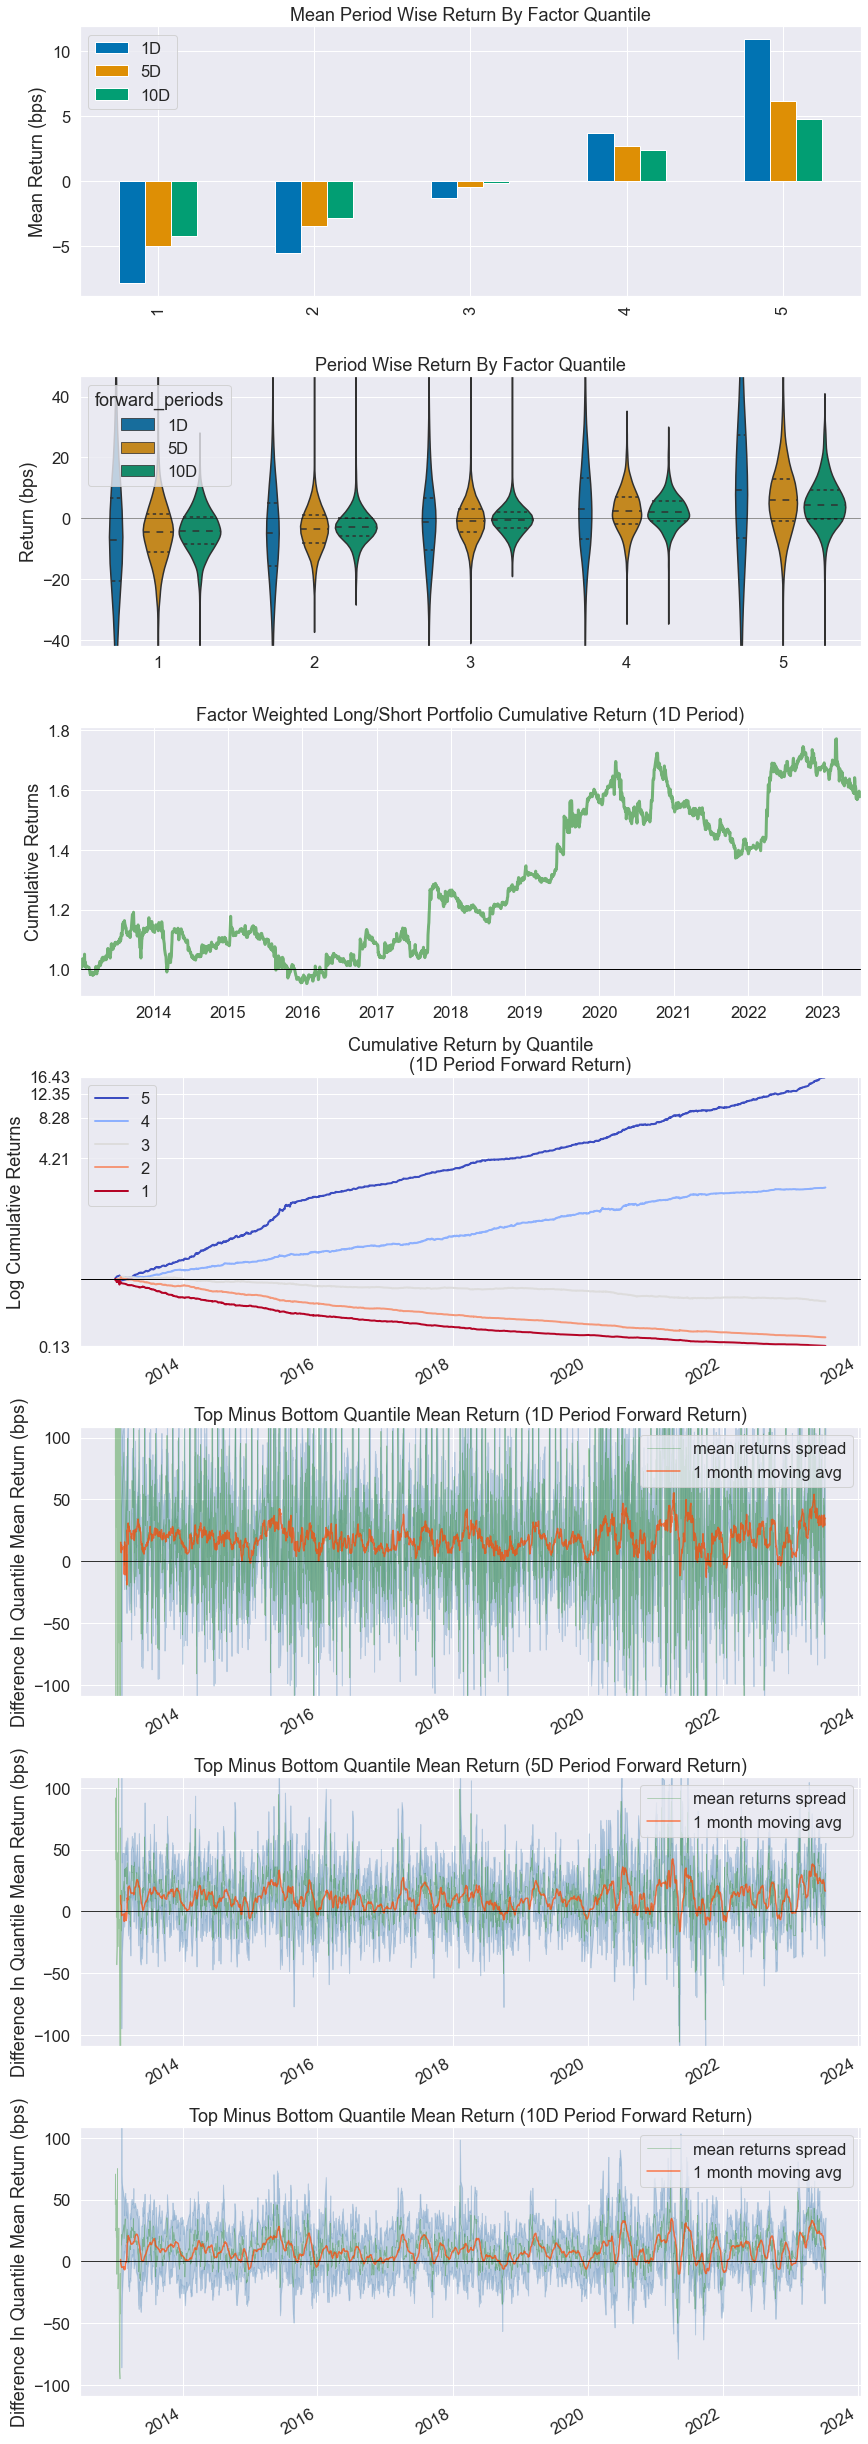

Information Analysis


,1D,5D,10D
IC Mean,0.025,0.037,0.043
IC Std.,0.100,0.094,0.089
Risk-Adjusted IC,0.252,0.392,0.483
t-stat(IC),12.770,19.854,24.510
p-value(IC),0.000,0.000,0.000
IC Skew,0.137,1.807,2.217
IC Kurtosis,43.689,38.032,35.561


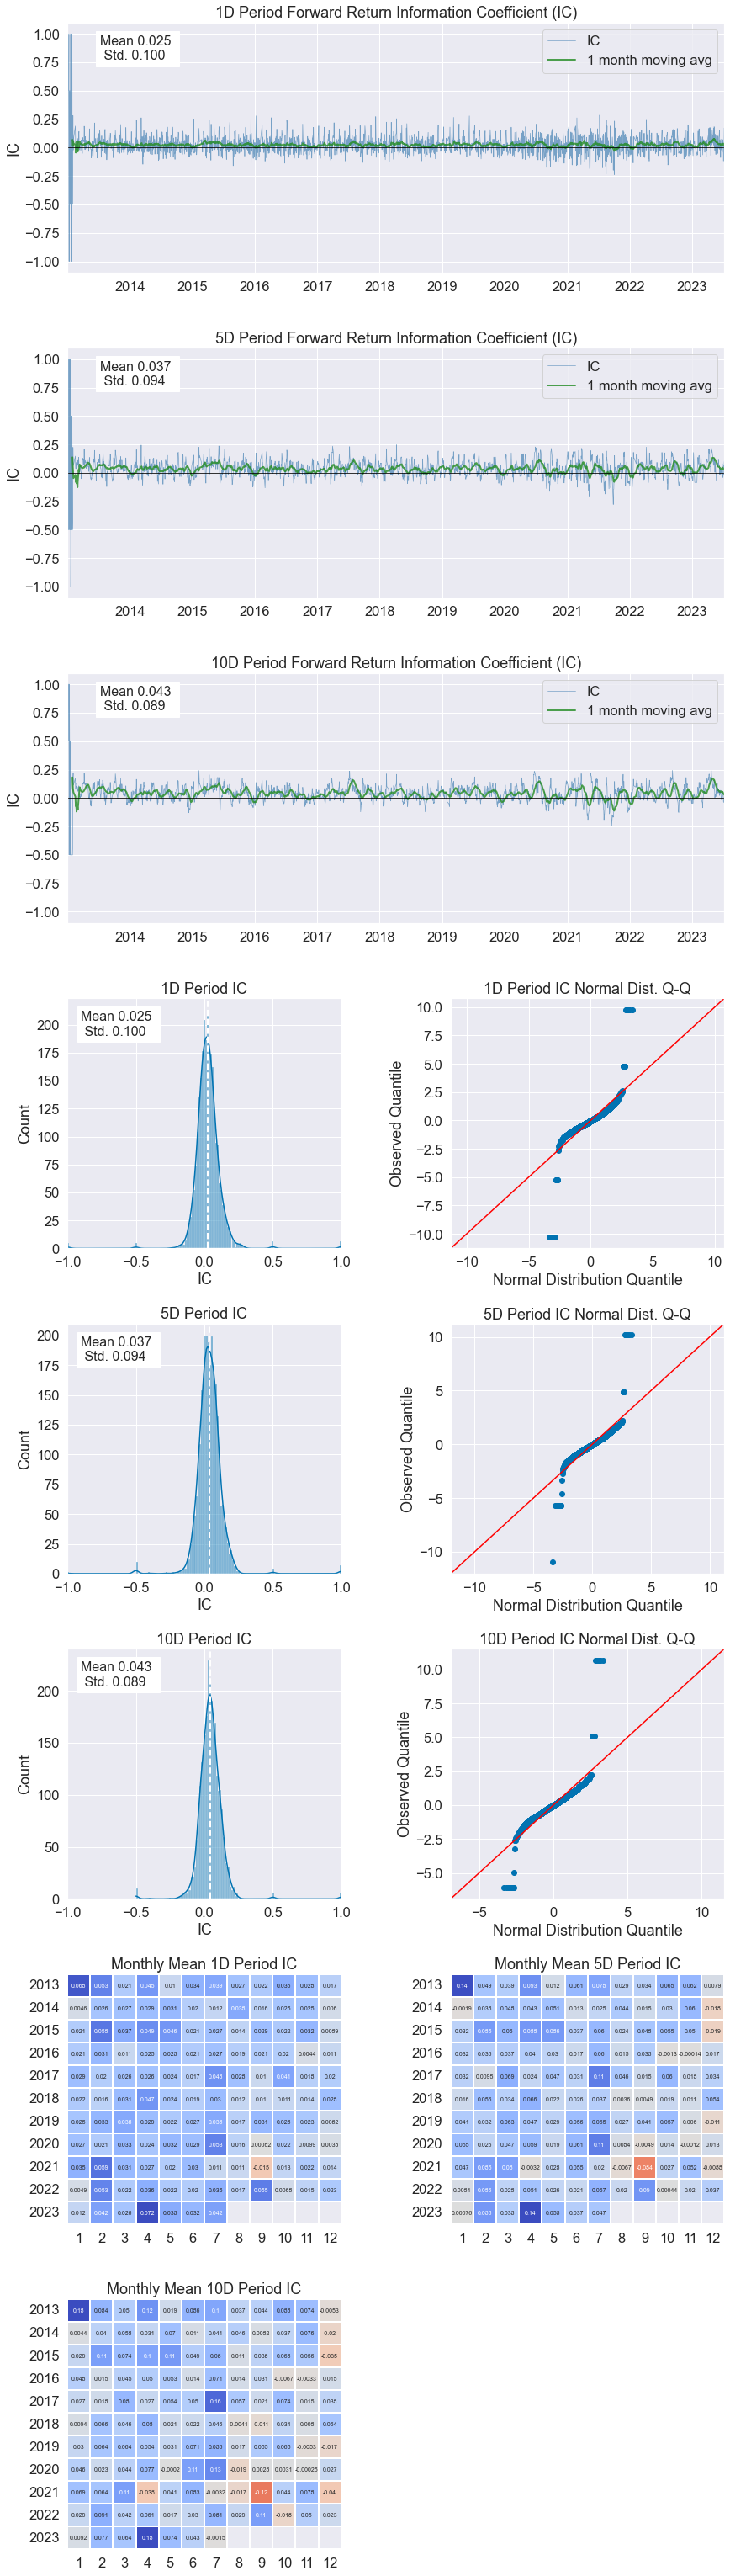

c:\Users\2022011702\Anaconda3\envs\zipline-tej2\lib\site-packages\alphalens\utils.py:951: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.026,0.111,0.215
Quantile 2 Mean Turnover,0.042,0.171,0.323
Quantile 3 Mean Turnover,0.046,0.182,0.341
Quantile 4 Mean Turnover,0.042,0.170,0.321
Quantile 5 Mean Turnover,0.027,0.116,0.224


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.978,0.894,0.788


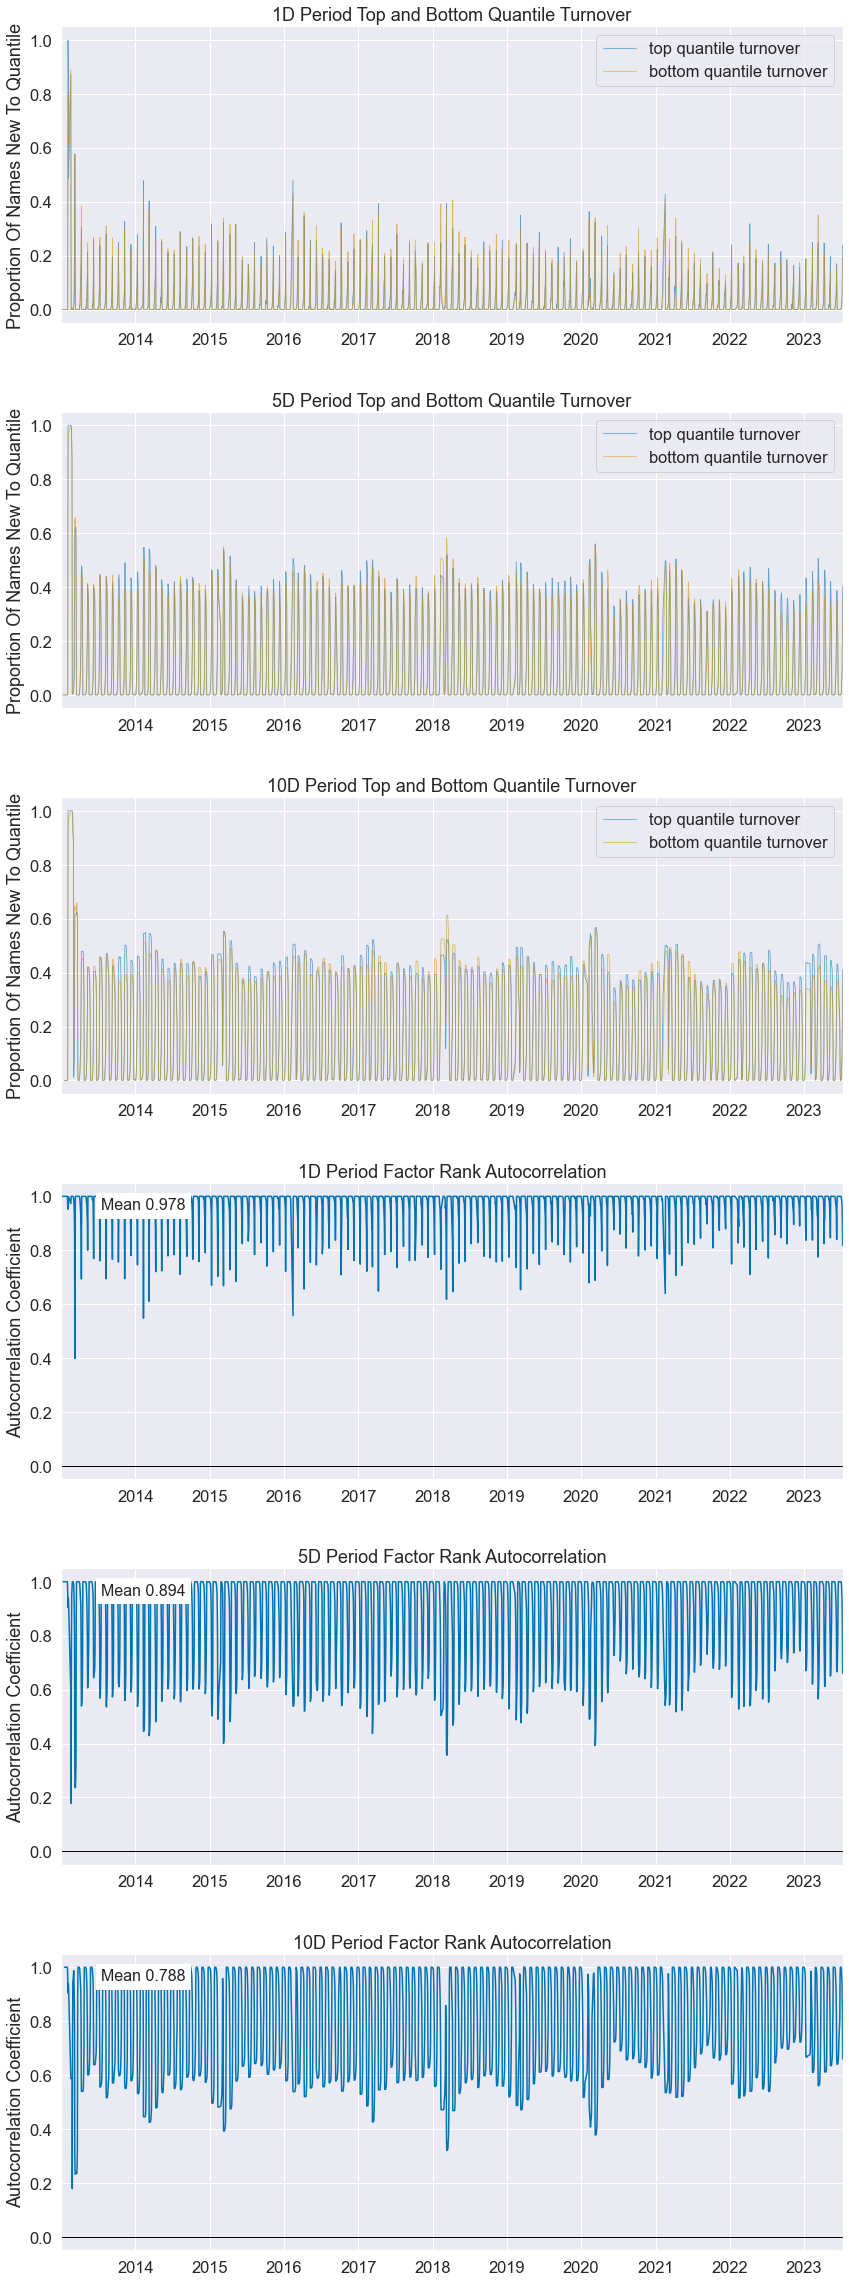

In [40]:
alphalens.tears.create_full_tear_sheet(factor_data)

## 5. 建構策略 (Strategy Developement)

本章節將運用`zipline.pipeline`的相關函數來建立交易策略的買賣訊號。<br>
以下過程:<br> 
**(1)** 定義 `CustomDataset` 函數: 定義策略需要的基本面變數(月營收成長率、毛利成長率、營業利益成長率、淨利成長率、產業別)。<br>
 **(2)** 使用 `DataFrameLoader` 函數，將第二節中用`TejToolAPI`函數抓取的基本面資料寫入`CustomDataset`函數定義的變數。<br>
**(3)** 定義 `compute_signals` 函數來設定篩選條件排除不符合條件的股票，以及門檻條件過濾出買進與賣出的股票，並轉換成買賣訊號。<br> 
**(4)** 最後利用 `run_pipeline` 函數產出買賣訊號整合成DataFrame輸出。

### 5.1 Define CustomDataset
創建 CustomDataset 物件 (該物件需繼承 `zipline.pipeline.data.dataset.DataSet`)。CustomDataset 定義每個欄位的資料型態，EX: int, float, str。另外也需要定義資料的地區(如本範例使用台灣地區的交易日)。

- 欄位:<br>
    - 月營收成長率_YoY: YoY_Monthly_Sales<br>
    - 毛利成長率: Gross_Margin_Growth_Rate_A<br>
    - 營業利益成長率: Operating_Income_Rate_percent_A<br>
    - 淨利成長率: Net_Income_Rate_percent_A<br>
    - 產業別: Industry<br>
- domain (地區):<br>
    - 控制交易日誌表，TW_EQUITIES 則代表台灣的交易日誌檔 (modified by TEJ Research Team)

In [41]:
from zipline.pipeline.data.dataset import Column, DataSet
from zipline.pipeline.domain import TW_EQUITIES

class CustomDataset(DataSet):
    
    Market_Cap_Dollars = Column(dtype=float)
    YoY_Monthly_Sales = Column(dtype=float)
    Gross_Margin_Growth_Rate_A = Column(dtype=float)
    Operating_Income_Growth_Rate_A = Column(dtype=float)
    Net_Income_Growth_Rate_A = Column(dtype=float)
    Inventories_A = Column(dtype=float)
    Industry = Column(dtype=object)
    domain = TW_EQUITIES

### 5.2 Transform Data Throught DataFrameLoader
透過 `DataFrameLoader` 將基本面資料寫入`CustomDataset` 對應的欄位。

In [42]:
sids = bundle.asset_finder.equities_sids
assets = bundle.asset_finder.retrieve_all(sids)
symbol_mapping_sid = {i.symbol:i.sid for i in assets}

transform_data = data.set_index(['coid', 'mdate']).unstack('coid')
transform_data = transform_data.rename(columns = symbol_mapping_sid)

In [43]:
transform_data.head(5)

ROI                                          \
coid                         0       1       2       3       4       5      
mdate                                                                       
2013-01-02 00:00:00+00:00  0.2571  0.2677  0.0000  0.9375  0.4491  0.4695   
2013-01-03 00:00:00+00:00 -0.3846  0.1335  0.3610  1.2384  1.3413 -0.4673   
2013-01-04 00:00:00+00:00  0.3861 -0.8000 -0.7194  1.8349  1.7647  0.0000   
2013-01-07 00:00:00+00:00 -0.2564 -0.5376  0.7246  2.1021  1.4451  0.4695   
2013-01-08 00:00:00+00:00 -1.0283 -0.4054  0.3597  0.5882 -0.5698 -1.4019   

                                                           ...  \
coid                         6       7       8       9     ...   
mdate                                                      ...   
2013-01-02 00:00:00+00:00 -1.0638  6.6390  0.7463  1.1278  ...   
2013-01-03 00:00:00+00:00  0.7168 -0.1297  0.7407 -0.3717  ...   
2013-01-04 00:00:00+00:00 -1.7794 -0.3896 -0.7353  0.3731  ...   
2013-01-07 00:00:00+00:00  1.4493  3.2595  1.9753  0.9294  ...   
2013-01-08 00:00:00+00:00  0.3571 -1.1364 -1.2107  0.1842  ...   

                          Total_Equity_Growth_Rate_TTM                      \
coid                                              1671 1672 1673 1674 1675   
mdate                                                                        
2013-01-02 00:00:00+00:00                          NaN  NaN  NaN  NaN  NaN   
2013-01-03 00:00:00+00:00                          NaN  NaN  NaN  NaN  NaN   
2013-01-04 00:00:00+00:00                          NaN  NaN  NaN  NaN  NaN   
2013-01-07 00:00:00+00:00                          NaN  NaN  NaN  NaN  NaN   
2013-01-08 00:00:00+00:00                          NaN  NaN  NaN  NaN  NaN   

                                                    
coid                      1676 1677 1678 1679 1680  
mdate                                               
2013-01-02 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  
2013-01-03 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  
2013-01-04 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  
2013-01-07 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  
2013-01-08 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  

[5 rows x 67240 columns]

In [44]:
from zipline.pipeline.loaders.frame import DataFrameLoader

inputs=[CustomDataset.YoY_Monthly_Sales,
        CustomDataset.Gross_Margin_Growth_Rate_A,
        CustomDataset.Operating_Income_Growth_Rate_A,
        CustomDataset.Net_Income_Growth_Rate_A,
        CustomDataset.Inventories_A,
        CustomDataset.Market_Cap_Dollars
        ]
Custom_loader = {i:DataFrameLoader(column=i, baseline=transform_data[i.name]) for i in inputs}
Custom_loader

{CustomDataset<TW>.YoY_Monthly_Sales::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1c8010293a0>,
 CustomDataset<TW>.Gross_Margin_Growth_Rate_A::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1c8010291c0>,
 CustomDataset<TW>.Operating_Income_Growth_Rate_A::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1c80694c670>,
 CustomDataset<TW>.Net_Income_Growth_Rate_A::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1c80694cd30>,
 CustomDataset<TW>.Inventories_A::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1c801126af0>,
 CustomDataset<TW>.Market_Cap_Dollars::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1c801126b50>}

### 5.3 Create Signal
利用`CustomDataset`的欄位定義交易策略的篩選、過濾指標。<br>
以`毛利成長率>0`、`營業利益率>0`、`淨利成長率>0`、為篩選指標，排除不符合此條件的股票。使用`月營收成長率`作為排序指標，買進月營收排名前 30 的股票，以此作為買賣的交易訊號。

In [45]:
from zipline.pipeline.filters import StaticAssets

def compute_signals():
    # filter
    gross_margin_filter = (CustomDataset.Gross_Margin_Growth_Rate_A.latest > 0)
    operating_income_filter = (CustomDataset.Operating_Income_Growth_Rate_A.latest > 0)
    net_income_filter = (CustomDataset.Net_Income_Growth_Rate_A.latest > 0)
    # mv_filter = CustomDataset.Market_Cap_Dollars.latest.percentile_between(min_percentile=50, max_percentile= 100)

    mask =  gross_margin_filter\
            & net_income_filter \
            & operating_income_filter\
            # & mv_filter 
            
    # signals
    MS = CustomDataset.YoY_Monthly_Sales.latest
    signals = MS.zscore(mask = mask)
    

    return Pipeline(columns={
        'signals' : signals,
        'YoY_Monthly_Sales' : MS,
        'filters': mask,
        'longs' : signals.top(30),
        },
    )

In [46]:
from zipline.pipeline import SimplePipelineEngine
from zipline.pipeline.data import EquityPricing
from zipline.pipeline.loaders import EquityPricingLoader
pricing_loader = EquityPricingLoader.without_fx(bundle.equity_daily_bar_reader,
                                                bundle.adjustment_reader)
def choose_loader(column):
    if column.name in EquityPricing._column_names:
        return pricing_loader
    elif column.name in CustomDataset._column_names:     
        return Custom_loader[column]
    else:
        raise Exception('Column not available')
    
engine = SimplePipelineEngine(get_loader = choose_loader,
                              asset_finder = bundle.asset_finder,
                              default_domain = TW_EQUITIES)

### 5.4 Run Pipeline
利用`run_pipeline`函數，將上一小節使用的相關欄位、定義的篩選指標、買賣的交易訊號整併，並輸出成MultiIndex(level_0=date, level_1asset)的DataFrame輸出。

In [47]:
pipeline_result = engine.run_pipeline(compute_signals(), start, end)
pipeline_result

signals  YoY_Monthly_Sales  \
2013-01-03 00:00:00+00:00 Equity(0 [1101])            NaN                NaN   
                          Equity(1 [1102])            NaN                NaN   
                          Equity(2 [1103])            NaN                NaN   
                          Equity(3 [1104])            NaN                NaN   
                          Equity(4 [1108])            NaN                NaN   
...                                                   ...                ...   
2023-07-24 00:00:00+00:00 Equity(1677 [9955])         NaN             -20.97   
                          Equity(1678 [9958])         NaN             150.61   
                          Equity(1679 [9960])   -0.061051             -59.39   
                          Equity(1680 [9962])   -0.059896             -34.73   
                          Equity(1681 [IR0001])       NaN                NaN   

                                                 filters  longs  
2013-01-03 00:00:00+00:00 Equity(0 [1101])         False  False  
                          Equity(1 [1102])         False  False  
                          Equity(2 [1103])         False  False  
                          Equity(3 [1104])         False  False  
                          Equity(4 [1108])         False  False  
...                                                  ...    ...  
2023-07-24 00:00:00+00:00 Equity(1677 [9955])      False  False  
                          Equity(1678 [9958])      False  False  
                          Equity(1679 [9960])       True  False  
                          Equity(1680 [9962])       True  False  
                          Equity(1681 [IR0001])    False  False  

[3859702 rows x 4 columns]

In [48]:
pipeline_result[(pipeline_result['longs']==True)]

signals  YoY_Monthly_Sales  \
2013-04-29 00:00:00+00:00 Equity(247 [2062])  -1.361015               0.07   
                          Equity(615 [3105])   1.013267               2.71   
                          Equity(1223 [6176])  0.347748               1.97   
2013-04-30 00:00:00+00:00 Equity(247 [2062])  -1.361015               0.07   
                          Equity(615 [3105])   1.013267               2.71   
...                                                 ...                ...   
2023-07-24 00:00:00+00:00 Equity(1341 [6472]) -0.049612             185.00   
                          Equity(1444 [6733]) -0.053163             109.14   
                          Equity(1454 [6762]) -0.053933              92.69   
                          Equity(1506 [8048]) -0.054081              89.52   
                          Equity(1638 [8996]) -0.053913              93.12   

                                               filters  longs  
2013-04-29 00:00:00+00:00 Equity(247 [2062])      True   True  
                          Equity(615 [3105])      True   True  
                          Equity(1223 [6176])     True   True  
2013-04-30 00:00:00+00:00 Equity(247 [2062])      True   True  
                          Equity(615 [3105])      True   True  
...                                                ...    ...  
2023-07-24 00:00:00+00:00 Equity(1341 [6472])     True   True  
                          Equity(1444 [6733])     True   True  
                          Equity(1454 [6762])     True   True  
                          Equity(1506 [8048])     True   True  
                          Equity(1638 [8996])     True   True  

[75035 rows x 4 columns]

## 6. 回測 (Backtest)
zipline 核心功能
1. 定義 initialize 設定

2. 定義 rebalance 條件設定
3. 定義 record_vars 交易過程資訊
4. 定義 before_trading_start
5. 執行回測

### 6.1 Define initialize
屬性:
- context.n_longs: 長部位檔數
- context.n_shorts: 短部位檔數
- context.min_positions: 最小持倉數
- context.universe: 股票池(同前面定義的ticker)
- context.tradeday: 執行交易日(未定義則為每日交易)
- context.set_benchmark: 設定set_benchmark<br>

設定 benchmark:<br>
context.set_benchmark(symbol('IR0001')) -> IR0001 為台灣加權報酬指數

設定交易成本:<br>
set_commission(commission.PerDollar(cost=commission_cost))

設定滑價:<br>
set_slippage(slippage.FixedSlippage(spread=0.00))

In [49]:
## 設定每月交易
from zipline.utils.calendar_utils import get_calendar 
tz = 'UTC'
calendar_name='TEJ'
_tradeday = [pd.Timestamp(year=i, month=m, day=15,tz=tz) for i in range(int(start_dt.strftime('%Y')),
                                                                        int(end_dt.strftime('%Y'))) for m in range(1,13)]
                              
tradeday= [get_calendar(calendar_name).next_open(pd.Timestamp(i)).strftime('%Y-%m-%d')
           if  get_calendar(calendar_name).is_session(i)==False
           else i.strftime('%Y-%m-%d') 
           for i in _tradeday]

tradeday

['2013-01-15',
 '2013-02-18',
 '2013-03-15',
 '2013-04-15',
 '2013-05-15',
 '2013-06-17',
 '2013-07-15',
 '2013-08-15',
 '2013-09-16',
 '2013-10-15',
 '2013-11-15',
 '2013-12-16',
 '2014-01-15',
 '2014-02-17',
 '2014-03-17',
 '2014-04-15',
 '2014-05-15',
 '2014-06-16',
 '2014-07-15',
 '2014-08-15',
 '2014-09-15',
 '2014-10-15',
 '2014-11-17',
 '2014-12-15',
 '2015-01-15',
 '2015-02-24',
 '2015-03-16',
 '2015-04-15',
 '2015-05-15',
 '2015-06-15',
 '2015-07-15',
 '2015-08-17',
 '2015-09-15',
 '2015-10-15',
 '2015-11-16',
 '2015-12-15',
 '2016-01-15',
 '2016-02-15',
 '2016-03-15',
 '2016-04-15',
 '2016-05-16',
 '2016-06-15',
 '2016-07-15',
 '2016-08-15',
 '2016-09-19',
 '2016-10-17',
 '2016-11-15',
 '2016-12-15',
 '2017-01-16',
 '2017-02-15',
 '2017-03-15',
 '2017-04-17',
 '2017-05-15',
 '2017-06-15',
 '2017-07-17',
 '2017-08-15',
 '2017-09-15',
 '2017-10-16',
 '2017-11-15',
 '2017-12-15',
 '2018-01-15',
 '2018-02-21',
 '2018-03-15',
 '2018-04-16',
 '2018-05-15',
 '2018-06-15',
 '2018-07-

In [50]:
from zipline.api import (attach_pipeline,
                         pipeline_output,
                         record,
                         schedule_function,
                         set_slippage,
                         set_commission,
                         order_target,
                         order_target_percent,
                         set_benchmark,
                         symbol,
                         get_datetime,
                         get_open_orders,
                         cancel_order,
                         order,
                         set_max_leverage,
                         get_open_orders,
                         cancel_order
                         )

from zipline.finance import commission
from zipline.utils.events import date_rules, time_rules
from collections import defaultdict
commission_cost = 0.001425 + 0.003 / 2

def initialize(context):
    """
    Called once at the start of the algorithm.
    """

    context.universe = assets
    context.tradeday = tradeday
    
    context.set_benchmark(symbol('IR0001'))
    
    context.longs = []
    context.shorts = []
    
    #   交易成本
    set_commission(commission.PerDollar(cost=commission_cost))

    #     schedule_function
    schedule_function(func=rebalance,
                      date_rule=date_rules.every_day(),
                      time_rule=time_rules.market_open)
    
    schedule_function(func=record_vars,
                      date_rule=date_rules.every_day(),
                      time_rule=time_rules.market_close)

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### 6.2 Define Rebalance
定義再平衡條件 <br>


當前交易時點 get_datetime().strftime('%Y-%m-%d') 為設定之交易日 context.tradeday

交易名單中若有符合條件之股票 -> 下單 order_target

In [51]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)
    if get_datetime().strftime('%Y-%m-%d') in context.tradeday: 
        # print(context.trades, len(context.trades))

        open_orders = get_open_orders()
        for asset in open_orders:
            for i in open_orders[asset]:
                cancel_order(i)                
                log.info('Cancel_order(month_start):' + \
                       " created: " + str(i.created.strftime('%Y-%m-%d')) + \
                         " asset: " + str(i.sid) + \
                         ", amount: " + str(i.amount)+\
                         ", filled: " + str(i.filled)) 
        
        for stock, trade in context.trades.items():
            if not trade:
                order_target(stock, 0)
            else:
                trades[trade].append(stock)
        ## Only Long
        context.longs = len(trades[1])
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs * 0.8)

### 6.3 Define Record variables
紀錄交易的中間資訊
- context.account.leverage: 帳戶的槓桿比率


- context.longs
- context.shorts

In [52]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """

    record(leverage=context.account.leverage,
           close=data.current(context.universe, 'close'),
           longs=context.longs,
           )

### 6.4 Define before_trading_start
- output: 產生 pipeline 運算後的 signals


- context.trades: 符合交易訊號的個股

In [53]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    context.output = output
    context.trades = (output['longs'].astype(int)
                      .reset_index()
                      .drop_duplicates()
                      .set_index('index')
                      .squeeze())

In [54]:
def analyze(context, perf):
    
    fig = plt.figure(figsize=(16, 12))
    
    # First chart(累計報酬)
    ax = fig.add_subplot(311) 
    ax.set_title('Strategy Results') 
    ax.plot(perf['algorithm_period_return'], linestyle='-', 
                label='algorithm period return', linewidth=3.0)
    ax.plot(perf['benchmark_period_return'], linestyle='-', 
                label='benchmark period return', linewidth=3.0)
    ax.legend()
    ax.grid(False)
    
    # Second chart(ending_cash)->觀察是否超買
    ax = fig.add_subplot(312)
    ax.plot(perf['ending_cash'], 
            label='ending_cash', linestyle='-', linewidth=1.0)
    ax.axhline(y=1,c='r',linewidth=0.3)
    ax.legend()
    ax.grid(True)

### 6.5 Run Algorithm
執行回測

[2023-08-14 08:08:54.655105]: INFO: earn_dividends: Equity(247 [2062]), cash_dividend amount: 2.0, pay_date: 2013-06-14, div_owed: 1042.0
[2023-08-14 08:09:03.672292]: INFO: earn_dividends: Equity(441 [2545]), cash_dividend amount: 7.5, pay_date: 2013-07-26, div_owed: 2625.0
[2023-08-14 08:09:04.427246]: INFO: earn_dividends: Equity(1044 [5234]), cash_dividend amount: 3.0, pay_date: 2013-07-26, div_owed: 1425.0
[2023-08-14 08:09:05.493400]: INFO: earn_dividends: Equity(759 [3529]), cash_dividend amount: 2.6999999999999997, pay_date: 2013-07-24, div_owed: 961.1999999999999
[2023-08-14 08:09:07.063262]: INFO: earn_dividends: Equity(1159 [6020]), cash_dividend amount: 0.0275, pay_date: 2013-07-31, div_owed: 42.735
[2023-08-14 08:09:07.065259]: INFO: handle_split: after split: asset: Equity(1159 [6020]), amount: 1553, cost_basis: 14.42, last_sale_price: 15.75
[2023-08-14 08:09:07.065259]: INFO: handle_split: returning cash: 10.86
[2023-08-14 08:09:07.840724]: INFO: earn_dividends: Equity(6

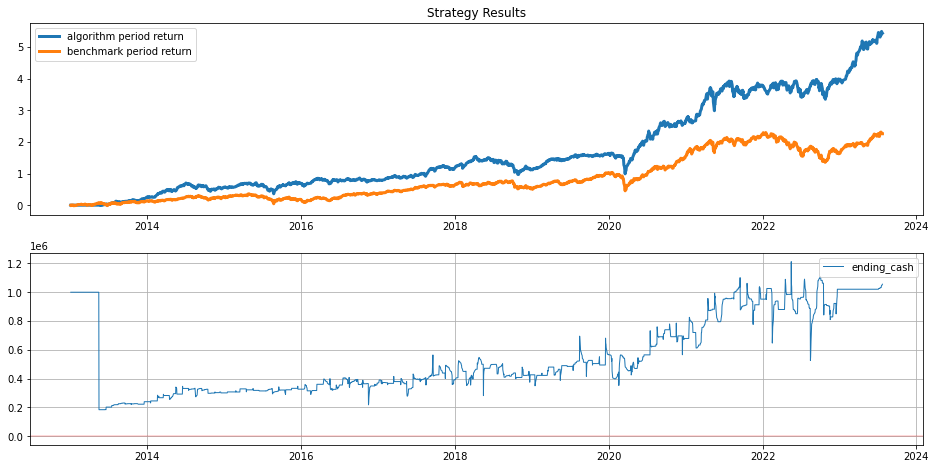

In [55]:
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar

capital_base = 1e6
calendar_name = 'TEJ'

# Running a Backtest
results = run_algorithm(start=start_dt,            
                        end=end_dt,                          
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=capital_base,
                        data_frequency='daily',
                        analyze=analyze,
                        bundle=bundle_name,
                        trading_calendar=get_calendar(calendar_name),
                        custom_loader=Custom_loader)

In [56]:
results.T

,2013-01-02 13:30:00+08:00,2013-01-03 13:30:00+08:00,2013-01-04 13:30:00+08:00,2013-01-07 13:30:00+08:00,2013-01-08 13:30:00+08:00,2013-01-09 13:30:00+08:00,2013-01-10 13:30:00+08:00,2013-01-11 13:30:00+08:00,2013-01-14 13:30:00+08:00,2013-01-15 13:30:00+08:00,...,2023-07-11 13:30:00+08:00,2023-07-12 13:30:00+08:00,2023-07-13 13:30:00+08:00,2023-07-14 13:30:00+08:00,2023-07-17 13:30:00+08:00,2023-07-18 13:30:00+08:00,2023-07-19 13:30:00+08:00,2023-07-20 13:30:00+08:00,2023-07-21 13:30:00+08:00,2023-07-24 13:30:00+08:00
period_open,2013-01-02 09:01:00+08:00,2013-01-03 09:01:00+08:00,2013-01-04 09:01:00+08:00,2013-01-07 09:01:00+08:00,2013-01-08 09:01:00+08:00,2013-01-09 09:01:00+08:00,2013-01-10 09:01:00+08:00,2013-01-11 09:01:00+08:00,2013-01-14 09:01:00+08:00,2013-01-15 09:01:00+08:00,...,2023-07-11 09:01:00+08:00,2023-07-12 09:01:00+08:00,2023-07-13 09:01:00+08:00,2023-07-14 09:01:00+08:00,2023-07-17 09:01:00+08:00,2023-07-18 09:01:00+08:00,2023-07-19 09:01:00+08:00,2023-07-20 09:01:00+08:00,2023-07-21 09:01:00+08:00,2023-07-24 09:01:00+08:00
period_close,2013-01-02 13:30:00+08:00,2013-01-03 13:30:00+08:00,2013-01-04 13:30:00+08:00,2013-01-07 13:30:00+08:00,2013-01-08 13:30:00+08:00,2013-01-09 13:30:00+08:00,2013-01-10 13:30:00+08:00,2013-01-11 13:30:00+08:00,2013-01-14 13:30:00+08:00,2013-01-15 13:30:00+08:00,...,2023-07-11 13:30:00+08:00,2023-07-12 13:30:00+08:00,2023-07-13 13:30:00+08:00,2023-07-14 13:30:00+08:00,2023-07-17 13:30:00+08:00,2023-07-18 13:30:00+08:00,2023-07-19 13:30:00+08:00,2023-07-20 13:30:00+08:00,2023-07-21 13:30:00+08:00,2023-07-24 13:30:00+08:00
ending_exposure,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5311114.9,5301295.4,5279319.6,5375858.2,5424565.8,5343161.35,5407556.6,5443631.1,5416168.25,5378056.65
returns,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.003845,-0.00155,-0.002475,0.015295,0.00762,-0.012603,0.011674,0.006245,-0.004231,-0.004485
portfolio_value,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,6337107.904475,6327288.404475,6311630.604475,6408169.204475,6456997.464475,6375618.834475,6450045.184475,6490325.984475,6462863.134475,6433876.044017
ending_value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5311114.9,5301295.4,5279319.6,5375858.2,5424565.8,5343161.35,5407556.6,5443631.1,5416168.25,5378056.65
gross_leverage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.838098,0.837846,0.836443,0.838907,0.840107,0.838062,0.838375,0.83873,0.838045,0.835897
short_value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
treasury_return,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
net_leverage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.838098,0.837846,0.836443,0.838907,0.840107,0.838062,0.838375,0.83873,0.838045,0.835897


## 7. 策略績效分析 (Performance Analysis)

運用`PyFolio`進行Performance Analysis 


In [57]:
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.plotting import (plot_perf_stats,
                              show_perf_stats,
                              plot_rolling_beta,
                              plot_rolling_returns,
                              plot_rolling_sharpe,
                              plot_drawdown_periods,
                              plot_drawdown_underwater)
from pyfolio.tears import *
from pyfolio.timeseries import (perf_stats,
                                extract_interesting_date_ranges,
                                sharpe_ratio,
                                sortino_ratio)

import empyrical

### 7.1 Detail in Transaction
- returns
- positions
- transactions

In [58]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [59]:
returns

2013-01-02 00:00:00+08:00    0.000000
2013-01-03 00:00:00+08:00    0.000000
2013-01-04 00:00:00+08:00    0.000000
2013-01-07 00:00:00+08:00    0.000000
2013-01-08 00:00:00+08:00    0.000000
                               ...   
2023-07-18 00:00:00+08:00   -0.012603
2023-07-19 00:00:00+08:00    0.011674
2023-07-20 00:00:00+08:00    0.006245
2023-07-21 00:00:00+08:00   -0.004231
2023-07-24 00:00:00+08:00   -0.004485
Name: returns, Length: 2581, dtype: float64

In [60]:
positions

sid,Equity(3 [1104]),Equity(5 [1109]),Equity(18 [1227]),Equity(19 [1229]),Equity(23 [1234]),Equity(28 [1264]),Equity(29 [1268]),Equity(35 [1308]),Equity(38 [1312]),Equity(41 [1315]),...,Equity(1661 [9933]),Equity(1665 [9938]),Equity(1667 [9940]),Equity(1672 [9945]),Equity(1673 [9946]),Equity(1677 [9955]),Equity(1678 [9958]),Equity(1679 [9960]),Equity(1680 [9962]),cash
index,,,,,,,,,,,,,,,,,,,,,
2013-05-16 00:00:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,26716.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.833941e+05
2013-05-17 00:00:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,26777.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.833941e+05
2013-05-20 00:00:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,26716.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.833941e+05
2013-05-21 00:00:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,27024.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.833941e+05
2013-05-22 00:00:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,26839.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.833941e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-18 00:00:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.032457e+06
2023-07-19 00:00:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.042489e+06
2023-07-20 00:00:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.046695e+06


In [61]:
transactions

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2013-05-16 05:30:00+00:00,Equity(123 [1535]),Equity(123 [1535]),83.441700,a2db7072873f4ed483c47eab10548bd5,319,None,2013-05-16 13:30:00+08:00,-26617.902300
2013-05-16 05:30:00+00:00,Equity(132 [1565]),Equity(132 [1565]),704.352000,8f6948092a5848ab829cbb7f99d4853b,38,None,2013-05-16 13:30:00+08:00,-26765.376000
2013-05-16 05:30:00+00:00,Equity(135 [1570]),Equity(135 [1570]),12.356175,7ea22af6966c419083151f788be825f2,2240,None,2013-05-16 13:30:00+08:00,-27677.832000
2013-05-16 05:30:00+00:00,Equity(192 [1777]),Equity(192 [1777]),52.026000,bcbef3e1cf17420ca7307a80c9ce8ff0,515,None,2013-05-16 13:30:00+08:00,-26793.390000
2013-05-16 05:30:00+00:00,Equity(199 [1789]),Equity(199 [1789]),70.235100,7080f7b1156d442585709865e68d3d7c,380,None,2013-05-16 13:30:00+08:00,-26689.338000
...,...,...,...,...,...,...,...,...
2022-12-20 05:30:00+00:00,Equity(1093 [5432]),Equity(1093 [5432]),29.435275,1eb5246e8f6043079edafa15cf4d0ef6,-200,None,2022-12-20 13:30:00+08:00,5887.055000
2022-12-20 05:30:00+00:00,Equity(1219 [6171]),Equity(1219 [6171]),24.037975,2c7a11189ff446f9b233414cee0b5b58,-1531,None,2022-12-20 13:30:00+08:00,36802.139725
2022-12-20 05:30:00+00:00,Equity(1423 [6680]),Equity(1423 [6680]),60.530250,8a23e3cf7a634cd0adfacca3ea22f635,348,None,2022-12-20 13:30:00+08:00,-21064.527000
2022-12-21 05:30:00+00:00,Equity(1093 [5432]),Equity(1093 [5432]),29.835075,1eb5246e8f6043079edafa15cf4d0ef6,-500,None,2022-12-21 13:30:00+08:00,14917.537500


### 7.2 Performance Visualization
- 敘述統計表
- 累計報酬率圖表
- 最大回檔
- 前10大持股
- rolling beta, volatility, sharpe ratio  

Start date,2013-01-02
End date,2023-07-24
Total months,122
,Backtest
Annual return,19.932%
Cumulative returns,543.388%
Annual volatility,14.551%
Sharpe ratio,1.32
Calmar ratio,0.80
Stability,0.95
Max drawdown,-24.839%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.84,2020-01-14,2020-03-19,2020-05-05,81
1,22.33,2018-04-09,2018-10-30,2019-07-10,328
2,20.45,2015-06-01,2015-08-24,2015-11-05,114
3,15.62,2014-07-03,2014-10-27,2015-06-01,238
4,15.35,2021-04-27,2021-05-17,2021-06-25,44


Stress Events,mean,min,max
Apr14,-0.02%,-2.58%,1.66%
Oct14,-0.28%,-2.99%,1.64%
Fall2015,0.23%,-5.71%,2.56%
New Normal,0.08%,-5.71%,4.81%


Top 10 long positions of all time,max
sid,
3693,6.90%
4743,6.03%
3287,5.81%
4171,5.64%
2615,5.59%
2108,5.45%
1541,5.29%
6472,5.29%
3147,5.20%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
3693,6.90%
4743,6.03%
3287,5.81%
4171,5.64%
2615,5.59%
2108,5.45%
1541,5.29%
6472,5.29%
3147,5.20%


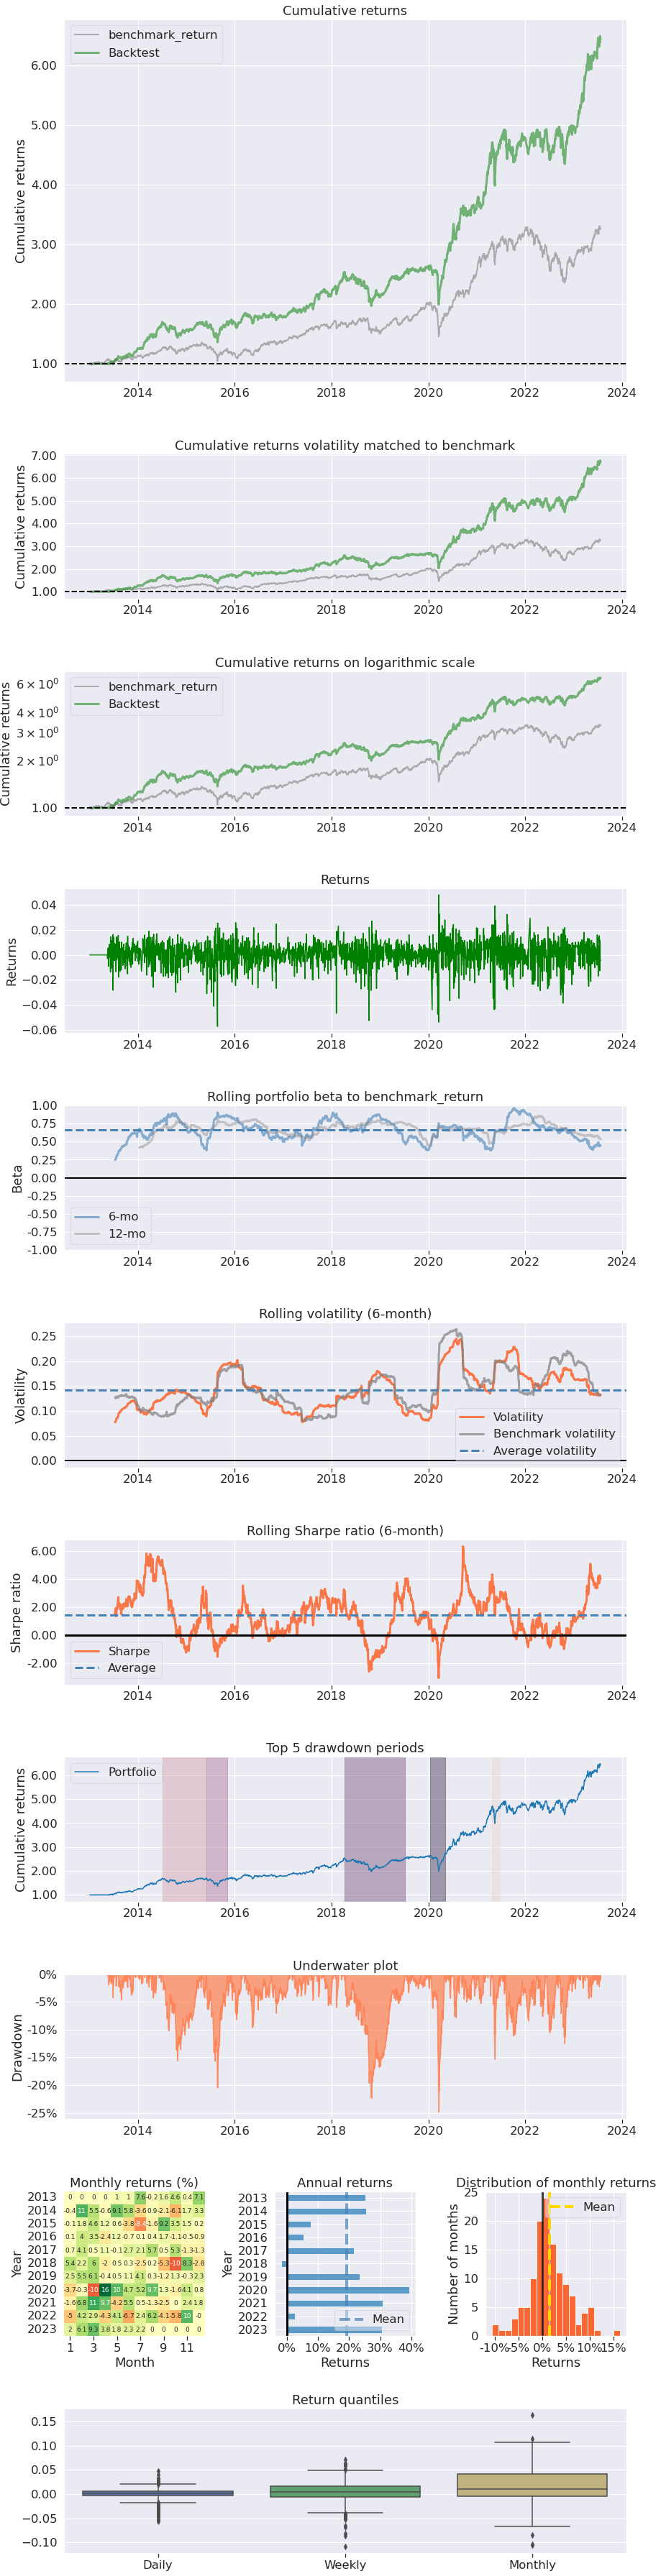

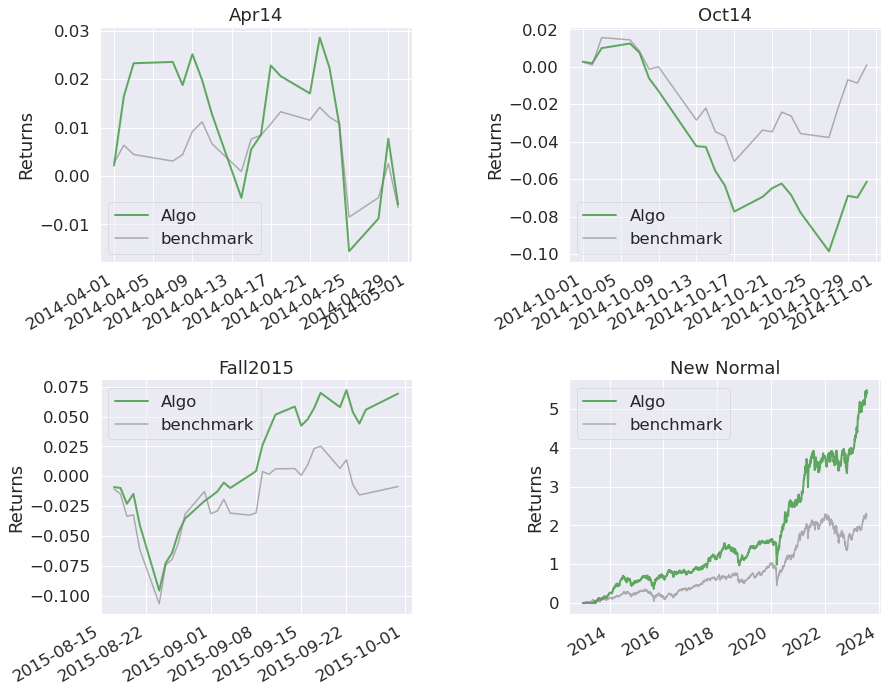

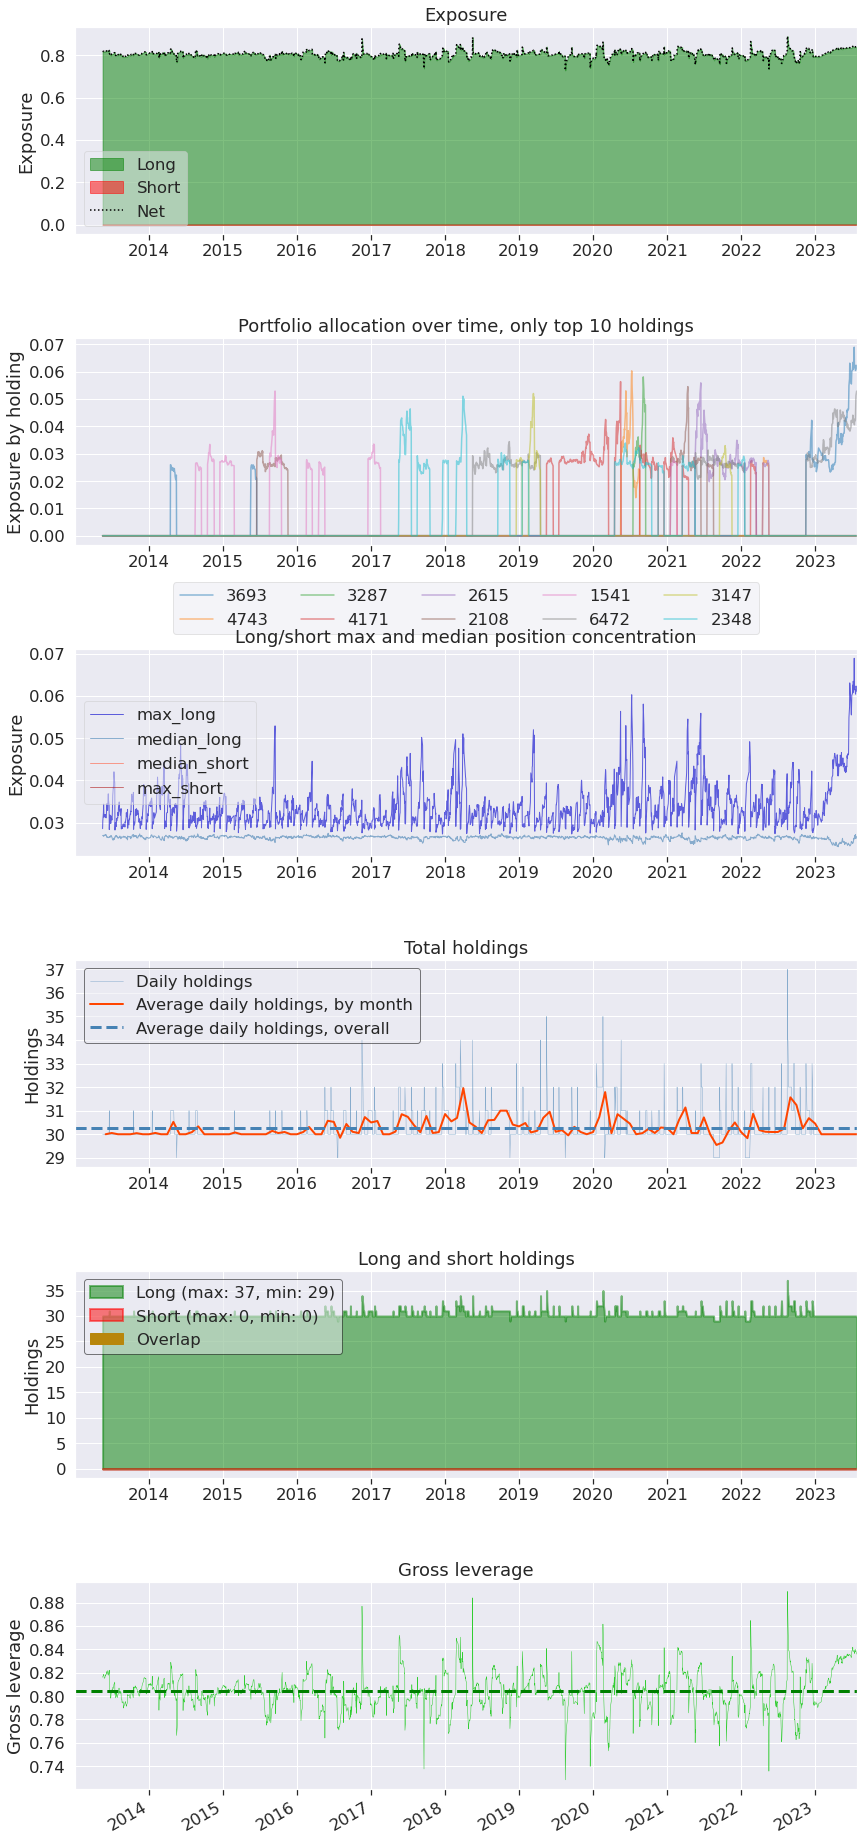

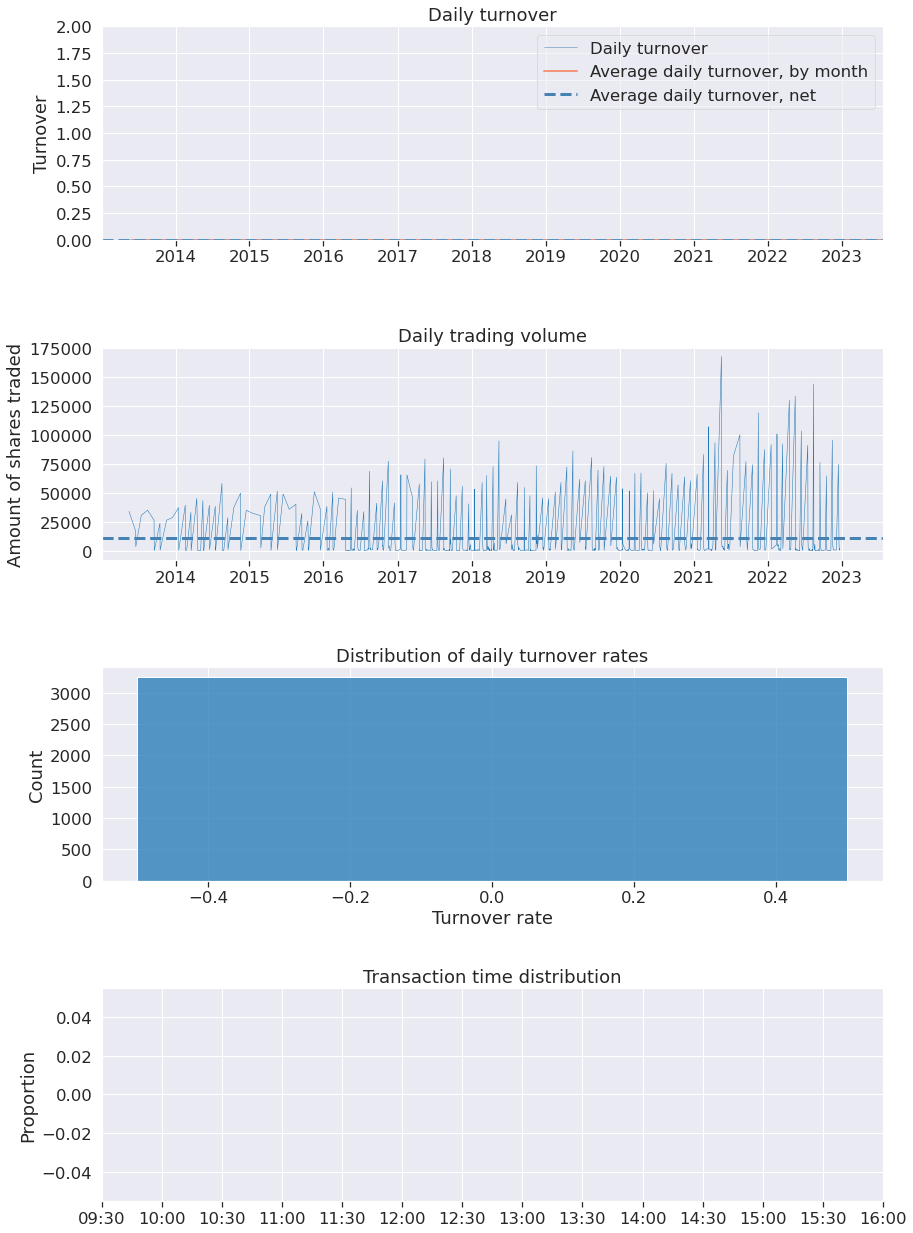

In [62]:
pf.tears.create_full_tear_sheet(returns,
                                     positions=positions,
                                     benchmark_rets=results['benchmark_return'],
                                     transactions=transactions)